
## Objective

- Network with Layer Normalization + L2



## Results:
- Parameters: 6720
- Best Training Accuracy: 98.69
- Best Test Accuracy: 99.45
-	Best Test Loss : 0.0187
-	Batch Size :128	
- L1 Factor :0
-	L2 Factor :0

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR



## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),                
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1
BATCH_SIZE_GPU = 128
BATCH_SIZE_CPU = 64
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE_GPU, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE_CPU)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Add batch normalization, no matter how complex is the data batch normalization can handle that. Batch norm fixes the problems with high contrast and low contract issues with the images.

Batch normaliztion maintains and stores a specific mean and std deviation for each layer, because it has to normlize it and untilmately it has to learn how to normalize the particular layer evntually even during the inference,  so there is a increase in the number of parameters after batch norm

In [5]:
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),  # Input 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # Input 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), #  Input 24x24 output 12x12 RF : 6x6
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  # Input 12x12 output 12x12 RF : 6x6
        )
        

        # CONVOLUTION BLOCK 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),  # Input 12x12 output 10x10 RF : 6x6
            nn.ReLU(),            
            nn.GroupNorm(1,10),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  # Input 10x10 output 8x8 RF : 10x10
            nn.ReLU(),            
            nn.GroupNorm(1,16),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=16, out_channels=18, kernel_size=(3, 3), padding=0, bias=False), # Input 8x8 output 6x6 RF : 14x14
            nn.ReLU(),            
            nn.GroupNorm(1,18),
            nn.Dropout(dropout_value)

        ) 
        
        # OUTPUT BLOCK
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # Input 6x6 output 6x6 RF : 18x18
            nn.ReLU(),            
            nn.GroupNorm(1,16),
            nn.Dropout(dropout_value))

        self.conv4 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)  # Input 6x6 output 6x6 RF : 18x18


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.avgpool2d(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
        GroupNorm-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7,weight_decay=1e-5)

scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=20,steps_per_epoch=len(train_loader))


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

    

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.4859178960323334 Batch_id=468 Accuracy=65.10: 100%|██████████| 469/469 [00:33<00:00, 13.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2797, Accuracy: 9401/10000 (94.01%)

EPOCH: 2


Loss=0.20144851505756378 Batch_id=468 Accuracy=92.94: 100%|██████████| 469/469 [00:34<00:00, 13.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1050, Accuracy: 9733/10000 (97.33%)

EPOCH: 3


Loss=0.13927023112773895 Batch_id=468 Accuracy=95.33: 100%|██████████| 469/469 [00:32<00:00, 14.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9855/10000 (98.55%)

EPOCH: 4


Loss=0.06847085803747177 Batch_id=468 Accuracy=96.26: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Loss=0.14418719708919525 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9883/10000 (98.83%)

EPOCH: 6


Loss=0.07223214954137802 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:32<00:00, 14.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9895/10000 (98.95%)

EPOCH: 7


Loss=0.09923876076936722 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9886/10000 (98.86%)

EPOCH: 8


Loss=0.06689905375242233 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:32<00:00, 14.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.1388230174779892 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:32<00:00, 14.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.044200871139764786 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:32<00:00, 14.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9902/10000 (99.02%)

EPOCH: 11


Loss=0.09045355767011642 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:32<00:00, 14.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.034888315945863724 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.028630012646317482 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:32<00:00, 14.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.028363080695271492 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:32<00:00, 14.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.07344210892915726 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:32<00:00, 14.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.04748951271176338 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:32<00:00, 14.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.12470344454050064 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:32<00:00, 14.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.06170326843857765 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.04289361834526062 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.03970155492424965 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:32<00:00, 14.25it/s]



Test set: Average loss: 0.0187, Accuracy: 9945/10000 (99.45%)



Text(0.5, 1.0, 'Test Accuracy')

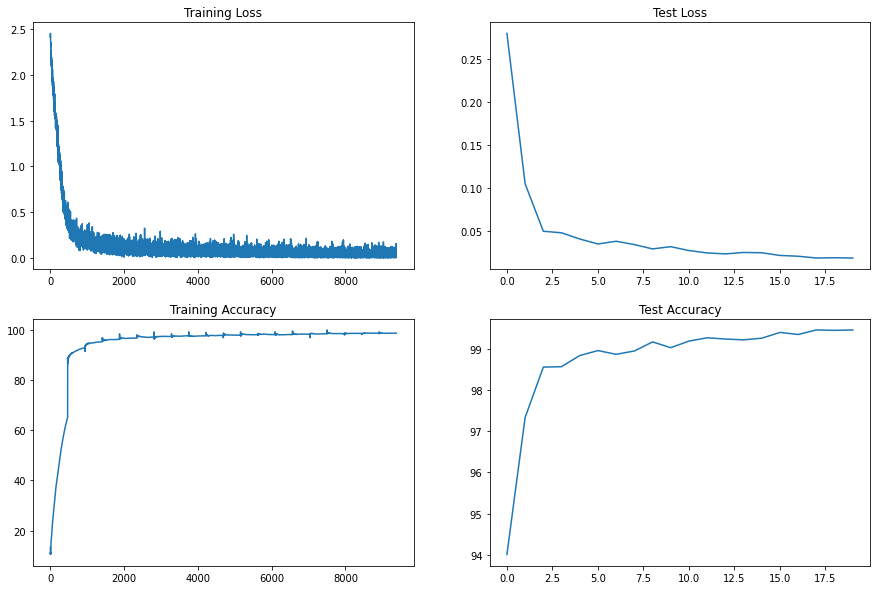

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Incorrect Predictions

In [11]:
def print_wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])   

  return list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))

In [12]:
wrong_predictions = print_wrong_predictions(test_loader,model,device)

In [13]:
print(f'Total wrong predictions are {len(wrong_predictions)}')

Total wrong predictions are 55


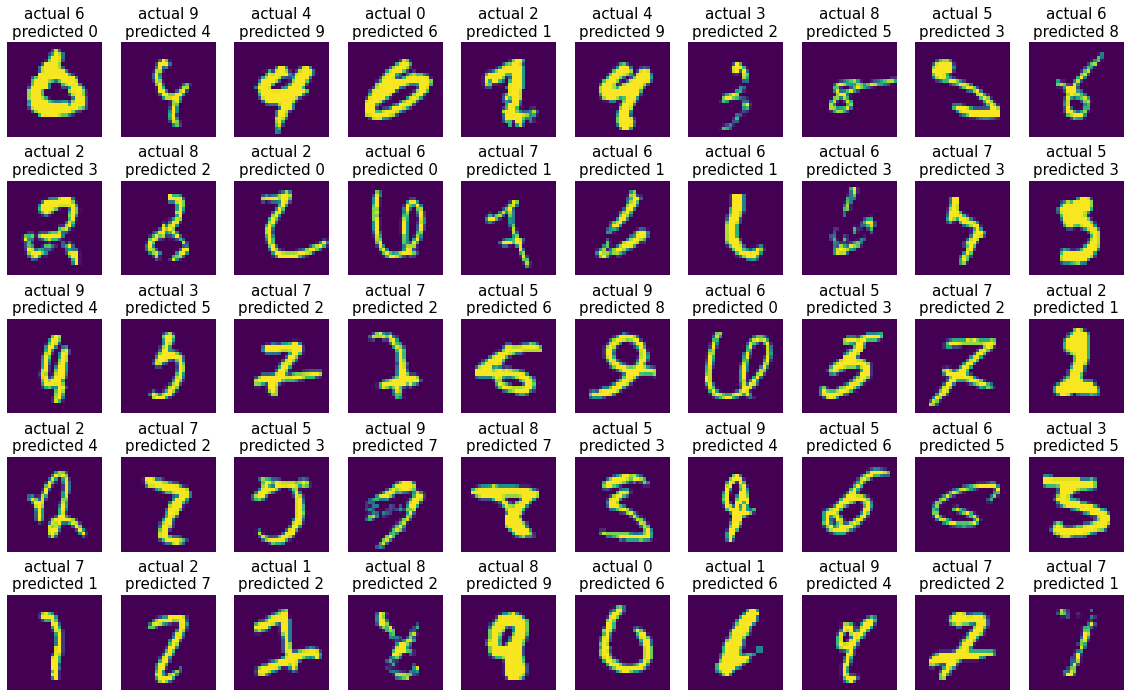

In [14]:
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(wrong_predictions[:50]):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())
plt.show()